# Counting bees with only graph methods

Code was created with accordance to article by Wenbing Tao, Hai Jin, Yimin Zhang, Liman Liu, and Desheng Wang.
<br>
Link: https://ieeexplore.ieee.org/document/4604825

In [1]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import math
import time
from datetime import timedelta
from skimage import io, filters, measure
from scipy import ndimage
import networkx as nx

In [2]:
# Graph does not need to be directed - we work directly only on ,,cut matrix"
# arr is array of image in grayscale (width x height) - it's elements are intenisities of pixels
# I - sensivity of weights for intensity changes
# X - sensivity of weights for spatial location between nodes


# Define norm in R^2

def norm(x1, y1, x2, y2):
    norm = math.sqrt((x1-x2) ** 2 + (y1-y2) ** 2)
    return norm

# Define function assigning weight to an edge

def set_capacity(arr, x1, y1, x2, y2, I, X):
    capacity = np.exp( - ((abs(arr[x1][y1] - arr[x2][y2]) / I + norm(x1, y1, x2, y2) / X )) )
    return capacity

# Create cut matrix for an image

def create_cut_matrix(arr, I, X):
    M = np.zeros((256,256))
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if i > 0:
                capacity = set_capacity(arr,i,j,i-1,j,I,X)
                M[arr[i-1][j]][arr[i][j]] += capacity
                M[arr[i][j]][arr[i-1][j]] += capacity
                if j > 0:
                    capacity = set_capacity(arr,i-1,j-1,i,j,I,X)
                    M[arr[i-1][j-1]][arr[i][j]] += capacity
                    M[arr[i][j]][arr[i-1][j-1]] += capacity
                if j < arr.shape[0] - 1:
                    capacity = set_capacity(arr,i,j,i-1,j+1,I,X)
                    M[arr[i-1][j+1]][arr[i][j]] += capacity
                    M[arr[i][j]][arr[i-1][j+1]] += capacity
            if j > 0:
                capacity = set_capacity(arr,i,j-1,i,j,I,X)
                M[arr[i][j-1]][arr[i][j]] += capacity
                M[arr[i][j]][arr[i][j-1]] += capacity     
    return M

# Define function that returns optimal cut for given cut matrix M, threshold of cut t and minimal cut

def get_NCut(t, M, NCut_min):
    cutAB = 0                                # cut with sets A and B
    assoAA = 0                               # sum of weights between pixels in A
    assoBB = 0                               # sum of weights between pixels in B
    for i in range(0,t+1):
        for j in range(t+1,256):
            cutAB += M[i][j]
    for i in range(0,t+1):
        for j in range(i,t+1):
            assoAA += M[i][j]
    for i in range(t+1,256):
        for j in range(i,256):
            assoBB += M[i][j]
    A = assoAA + cutAB
    B = assoBB + cutAB
    if A != 0 and B != 0:
        NCutAB = (cutAB / A) + (cutAB / B)    # get normalized cut
    else:
        NCutAB = NCut_min
    return NCutAB

# Get optimal threshold that results in minimal normalized cut for given ,,cut matrix" M 

def get_treshold(M):
    
    # Initialization
    t = 0
    t_min = 0
    NCut_min = 2
    
    # Search for best treshold and cut
    while t <= 255:
        NCutAB = get_NCut(t, M, NCut_min)
        if NCutAB < NCut_min:
            NCut_min = NCutAB
            t_min = t
        t += 1
    return NCut_min, t_min

# Process image with obtained threshold

def treshold_image(arr, treshold):
    result = arr
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if arr[i][j] > treshold :
                result[i][j] = 0
            else:
                result[i][j] = 1
    return result

In [102]:
# Create graph ,,binary graph" used for DFS search in thresholded image
# reached == 0 => node was not reached during DFS 
# weight == 0 or 1 depending on image binary threshold 

def create_binary_graph(im_arr):
    G = nx.Graph()
    for i in range(im_arr.shape[0]):
        for j in range(im_arr.shape[1]):
            G.add_node((i,j), weight = im_arr[i][j], reached = 0)      
            if i > 0:
                G.add_edge((i,j),(i-1,j))  
                if j > 0:
                    G.add_edge((i-1,j-1),(i,j))
                if j < im_arr.shape[0] - 1:
                    G.add_edge((i-1,j+1),(i,j))
            if j > 0:
                G.add_edge((i,j),(i,j-1))
    return G

# Count different objects by colouring DFS trees for thresholded image

def colouring_binary_picture(image_array):
    
    #Initialization
    G = create_binary_graph(image_array)
    result = image_array
    colour = 50
    stack = []
    banned_colours = []
    
    # DFS iterative way + colour assignment
    for node in G.nodes():
        counter = 0
        if G.nodes[node]['reached'] == 0 and G.nodes[node]['weight'] == 1:
            counter += 1
            colour += 1
            G.nodes[node]['reached'] = 1
            result[node[0]][node[1]] = colour
            stack.append(node)
            while len(stack) != 0:
                taken_node = stack.pop(0)
                counter += 1
                for neighbor in G.neighbors(taken_node):
                    if G.nodes[neighbor]['reached'] == 0 and G.nodes[neighbor]['weight'] == 1:
                        G.nodes[neighbor]['reached'] = 1
                        result[neighbor[0]][neighbor[1]] = colour
                        stack.append(neighbor)
                        
            # Search for ,,too big" or ,,too small" objects
            if counter > 2000 or counter < 20:
                banned_colours.append(colour)
                
    return result, banned_colours

# Remove too small or too big objects 
# Note: All thresholds for saying that something is ,,big" or ,,small" are (for now!) assigned in experimental way
#       Later I will try to set down an automatic threshold for such details

def remove_banned_objects(colour_array, banned_colours):
    result = colour_array
    
    for i in range(colour_array.shape[0]):
        for j in range(colour_array.shape[1]):
            if colour_array[i][j] in banned_colours:
                result[i][j] = 0
                
    return result

In [104]:
# image is an unopened picture, I and X need to be specified by user (possible automatic detection ??)

def pipeline(image, I, X):
    
    im = Image.open(image).convert('L')
    
    im_arr = np.array(im, dtype='int64')    # int for possibility to iterate!
    
    # Threshold picture by cut matrix method
    
    M = create_cut_matrix(im_arr, I, X)
    
    N, T = get_treshold(M)
    
    threshold_result = treshold_image(im_arr, T)
    
    # Process obtained picture for possibility to properly count the bees
    
    colour_result, banned_colours = colouring_binary_picture(threshold_result)
    
    result = remove_banned_objects(colour_result, banned_colours)
    
    # Number of bees equals to all different colours used minus colour "0" for the background
    
    unique_values = np.unique(result) 
    
    counter = len(unique_values) - 1
    
    print('There are {} objects in the image.'.format(counter))
    
    return result

There are 12 objects in the image.
Time of calcualtions: 0:00:05.141000


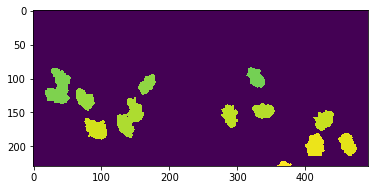

In [105]:
start_time = time.monotonic()
result = pipeline('3.png', 625, 4)
end_time = time.monotonic()
print('Time of calcualtions: {}'.format(timedelta(seconds = end_time - start_time)))
plt.imshow(result)

There are 12 objects in the image.
Time of calcualtions: 0:00:08.890000


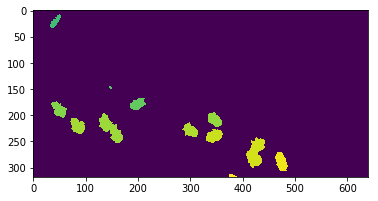

In [106]:
start_time = time.monotonic()
result = pipeline('2.png', 625, 4)
end_time = time.monotonic()
print('Time of calcualtions: {}'.format(timedelta(seconds = end_time - start_time)))
plt.imshow(result)

There are 0 objects in the image.
Time of calcualtions: 0:00:04.765000


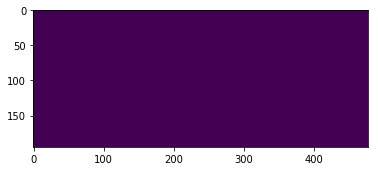

In [107]:
start_time = time.monotonic()
result = pipeline('4.png', 625, 4)
end_time = time.monotonic()
print('Time of calcualtions: {}'.format(timedelta(seconds = end_time - start_time)))
plt.imshow(result)

There are 9 objects in the image.
Time of calcualtions: 0:00:04.797000


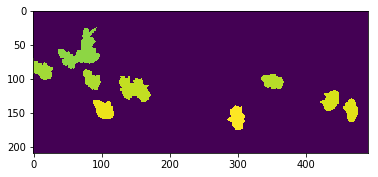

In [108]:
start_time = time.monotonic()
result = pipeline('5.png', 625, 4)
end_time = time.monotonic()
print('Time of calcualtions: {}'.format(timedelta(seconds = end_time - start_time)))
plt.imshow(result)

There are 7 objects in the image.
Time of calcualtions: 0:00:04.891000


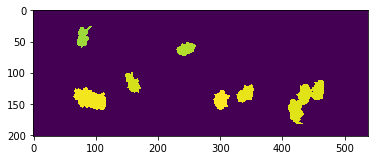

In [109]:
start_time = time.monotonic()
result = pipeline('6.png', 625, 4)
end_time = time.monotonic()
print('Time of calcualtions: {}'.format(timedelta(seconds = end_time - start_time)))
plt.imshow(result)

There are 8 objects in the image.
Time of calcualtions: 0:00:04.781000


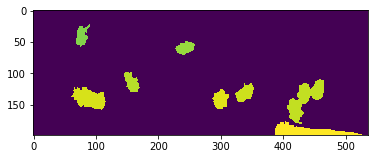

In [110]:
start_time = time.monotonic()
result = pipeline('7.png', 625, 4)
end_time = time.monotonic()
print('Time of calcualtions: {}'.format(timedelta(seconds = end_time - start_time)))
plt.imshow(result)